In [2]:
import os

os.environ["EQX_ON_ERROR"] = "nan"

import healpy as hp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa: F401
from jax_healpy.clustering import (
    combine_masks,
    find_kmeans_clusters,
    get_cutout_from_mask,
    get_fullmap_from_cutout,
)
from matplotlib.patches import Patch

from furax_cs.data.generate_maps import get_mask

# Set the style for the plots
plt.style.use("science")
font_size = 16
plt.rcParams.update(
    {
        "font.size": font_size,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
        "axes.titlesize": font_size,
        "font.family": "serif",  # or 'Times New Roman' to match LaTeX
        "legend.frameon": True,  # Add boxed legends
    }
)

out_folder = "plots"
os.makedirs(out_folder, exist_ok=True)

## K-means Clustering Demonstration

This cell generates a visualization of K-means clustering on the full sky to demonstrate the basic clustering algorithm. The plot shows how spherical K-means partitions the sky into distinct regions using spatial coordinates (RA/Dec converted to 3D Cartesian). This serves as a foundation example before showing the adaptive clustering methodology used in the main FURAX framework.

**Output:** `plots/kmeans_clustering.pdf` - Basic K-means clustering visualization

## Sky Region Mask Zones

This visualization shows the hierarchical Galactic mask structure used in the FURAX framework. The different colored regions represent varying levels of Galactic contamination exclusion:

- **GAL020_U/L**: Upper/Lower Galactic plane regions excluding 20% of sky
- **GAL040_U/L**: Upper/Lower Galactic plane regions excluding 40% of sky  
- **GAL060_U/L**: Upper/Lower Galactic plane regions excluding 60% of sky

These nested mask zones allow for adaptive component separation strategies where different spectral parameters can be applied to regions with varying foreground complexity.

**Output:** `plots/sky_region_mask_zones.pdf` - Hierarchical Galactic mask visualization

## Multi-Resolution Pixel Grouping

This plot demonstrates the multi-resolution approach used as a baseline comparison method. Unlike the adaptive K-means clustering, this method uses fixed HEALPix resolution downgrading (`ud_grade`) to create spatial patches. Different spectral parameters are assigned to pixels at different resolution scales, creating a hierarchical but non-adaptive partitioning of the sky.

This serves as the "PTEP baseline" mentioned in the paper, representing the traditional multi-resolution approach before introducing the innovation of adaptive K-means clustering.

**Output:** `plots/multi_resolution_pixel_grouping.pdf` - Traditional multi-resolution approach

## Spectral Parameter Maps from PySM3 Simulations

This visualization shows the true underlying spectral parameter maps used in the simulations, generated from PySM3 foreground models:

- **βd**: Dust spectral index (Modified Black Body index)
- **Td**: Dust temperature (Modified Black Body temperature)  
- **βs**: Synchrotron spectral index (Power Law index)

These maps represent the "ground truth" spatially-varying parameters that our component separation methods aim to recover or approximate. The d1s1 models from PySM3 provide realistic spatial variations in foreground properties that challenge component separation algorithms.

**Output:** `plots/mbb_index_map.pdf` - Ground truth spectral parameter maps

## Sky Components from FGBuster Framework

This plot shows the spectral parameter maps using the FGBuster framework's `get_sky` function with the c1d1s1 configuration. This represents the same underlying PySM3 simulations but accessed through the FGBuster interface, providing a comparison point for different framework implementations.

The three panels show:
- **βd**: Dust spectral index from dust component (d1 model)
- **Td**: Dust temperature from dust component (d1 model)  
- **βs**: Synchrotron spectral index from synchrotron component (s1 model)

This visualization demonstrates the consistency between different simulation frameworks and provides reference parameter maps for validation.

**Output:** `plots/sky_components.pdf` - FGBuster c1d1s1 parameter maps

## Multi-Resolution Patch Layout (PTEP Baseline)

This visualization shows the multi-resolution patching strategy used as the baseline comparison method (PTEP model). The approach combines different HEALPix resolution masks (GAL020, GAL040, GAL060) with varying downgrade factors for each spectral parameter:

- **βd**: Dust spectral index patches  
- **Td**: Dust temperature patches
- **βs**: Synchrotron spectral index patches

Each parameter gets a different resolution treatment across the three Galactic mask regions, creating a hierarchical but predetermined patch structure. This represents the traditional approach before the introduction of adaptive K-means clustering.

The method demonstrates how spectral parameters can be spatially organized, but lacks the data-driven optimization that K-means provides.

**Output:** Displayed inline - Multi-resolution patch layout visualization

## Adaptive K-means Patch Layout (Main Innovation)

This visualization demonstrates the **main innovation** of the FURAX framework: adaptive K-means clustering for component separation. Unlike the fixed multi-resolution approach, this method uses spherical K-means to create data-driven spatial patches that are optimized for each spectral parameter.

**Key Innovation Features:**
- **Adaptive clustering**: Different numbers of clusters per parameter (βd, Td, βs)
- **Hierarchical mask integration**: Combines GAL020_U, GAL040_U, GAL060_U, GAL060_L, GAL040_L, GAL020_L regions
- **Optimized patch counts**: Each region gets different cluster numbers based on foreground complexity
- **Spherical K-means**: Uses 3D Cartesian coordinates for proper spherical geometry

The three panels show the optimized patch layout for:
- **βd**: Dust spectral index (highest complexity, most clusters)
- **Td**: Dust temperature (moderate complexity)  
- **βs**: Synchrotron spectral index (lower complexity, fewer clusters)

This approach minimizes CMB reconstruction variance by adaptively partitioning the sky based on the underlying foreground structure.

**Output:** Displayed inline - Adaptive K-means patch layout (main contribution)

<Figure size 600x300 with 0 Axes>

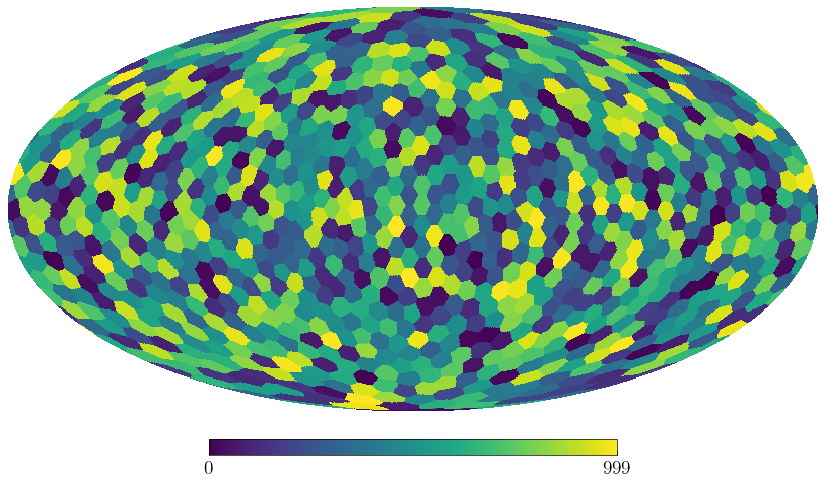

In [ ]:
nside = 256
npixels = hp.nside2npix(nside)

mask = jnp.ones(npixels)
(indices,) = jnp.where(mask == 1)

full_map = find_kmeans_clusters(mask, indices, 1000, jax.random.PRNGKey(0), max_centroids=1000)

# Set up subplots
fig = plt.figure(figsize=(6, 3))
# Plot each map
hp.mollview(full_map, bgcolor=(0.0,) * 4, title=None)
# Display the plot
plt.savefig(f"{out_folder}/kmeans_clustering.pdf", dpi=600, bbox_inches="tight", transparent=True)
plt.show()

<Figure size 700x300 with 0 Axes>

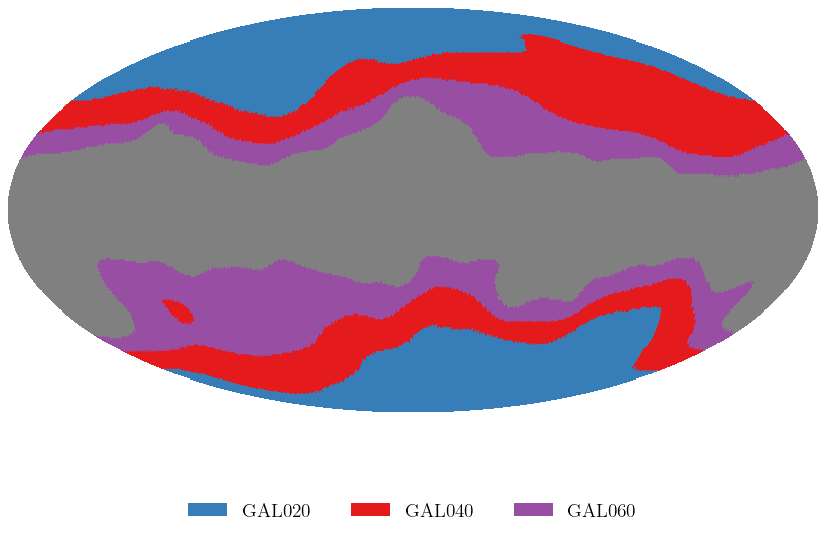

In [4]:
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load binary masks (without U/L divisions)
gal020 = get_mask("GAL020", nside=64)
gal040 = get_mask("GAL040", nside=64)
gal060 = get_mask("GAL060", nside=64)

# Combine into a single labeled mask
full_mask = gal020 * 1 + gal040 * 2 + gal060 * 3
full_mask = full_mask.astype(np.float64)
# Set 0s (unmasked regions) to hp.UNSEEN to hide them
full_mask[full_mask == 0] = hp.UNSEEN

# Define labels and values
labels = ["GAL020", "GAL040", "GAL060"]
values = [1, 2, 3]

# Define distinct colors
distinct_colors = [
    "#377eb8",  # blue
    "#e41a1c",  # red
    "#984ea3",  # purple
]

# Create colormap for values 1-3 (index 0 is ignored)
cmap = ListedColormap(["black"] + distinct_colors)

plt.figure(figsize=(7, 3))
# Plot with custom colormap and colorbar off
hp.mollview(
    full_mask,
    cbar=False,
    cmap=cmap,
    title=None,
    min=0,
    max=3,
    bgcolor=(0.0,) * 4,
)

# Create legend patches
legend_elements = [
    Patch(facecolor=color, label=label) for label, color in zip(labels, distinct_colors)
]

# Add legend below map
plt.legend(
    handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False
)

# Save and show
plt.savefig(
    f"{out_folder}/sky_region_mask_zones.pdf", dpi=1200, bbox_inches="tight", transparent=True
)
plt.show()

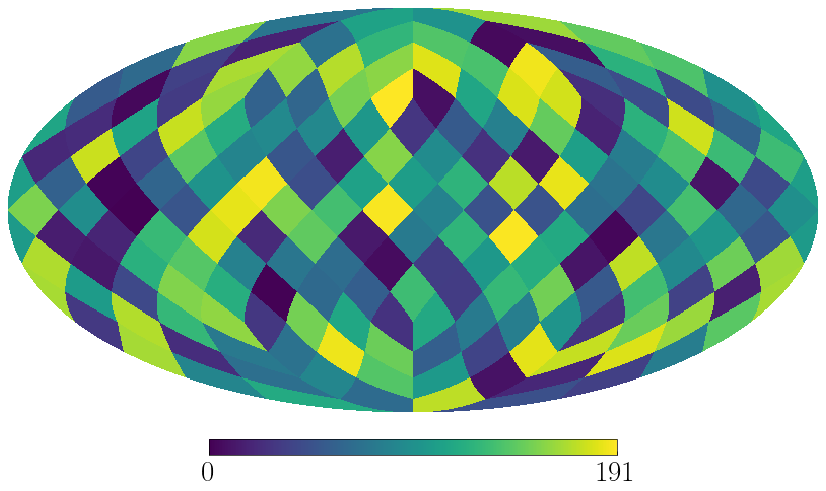

In [ ]:
# Load binary masks
np.random.seed(0)

nside = 64
npixels = hp.nside2npix(nside)
gal020 = np.ones(npixels)
npix = nside**2 * 12
ipix = np.arange(npix)


def ud_grade(ipix, nside_in, nside_out):
    if nside_out == 0:
        return np.zeros_like(ipix)
    else:
        lowered = hp.ud_grade(ipix, nside_out=nside_out)
        return hp.ud_grade(lowered, nside_out=nside_in)


ud_beta_d_map = ud_grade(ipix, nside, 4).astype(np.float64)

(indices,) = np.where(gal020 == 0)


def normalize_array(arr):
    unique_vals, indices = np.unique(arr, return_inverse=True)
    return indices.astype(np.float64)


def shuffle_labels(arr):
    unique_vals = np.unique(arr[arr != hp.UNSEEN])  # Ignore UNSEEN
    shuffled_vals = np.random.permutation(unique_vals)

    # Create mapping dict
    mapping = dict(zip(unique_vals, shuffled_vals))

    # Vectorized mapping
    shuffled_arr = np.vectorize(lambda x: mapping.get(x, hp.UNSEEN))(arr)
    return shuffled_arr.astype(np.float64)


ud_beta_d_map = normalize_array(ud_beta_d_map)
ud_beta_d_map[indices] = hp.UNSEEN

ud_beta_d_map = shuffle_labels(ud_beta_d_map)

hp.mollview(
    ud_beta_d_map,
    # cmap="cividis",  # or "cubehelix", "YlGnBu", "Greys", etc.
    cbar=True,
    title=None,
)
plt.savefig(
    f"{out_folder}/multi_resolution_pixel_grouping.pdf",
    dpi=1200,
    bbox_inches="tight",
    transparent=True,
)

In [4]:
!generate_masks --nside 512

/home/wassim/micromamba/envs/fg/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Generated mask for nside 512


/tmp/ipykernel_59862/2094396587.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


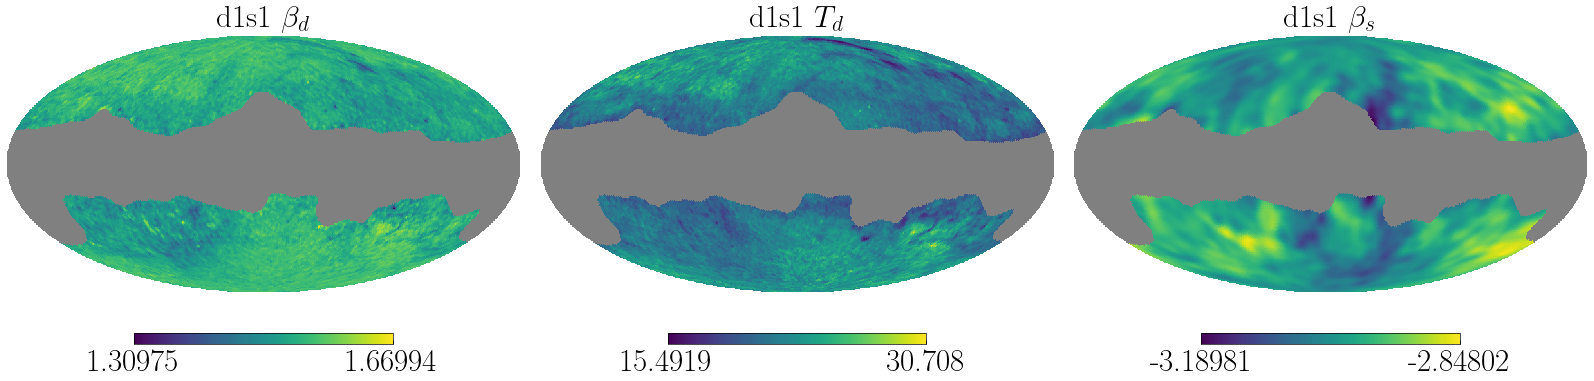

In [10]:
from fgbuster import get_sky

plot_vertical = False  # Set to True for vertical layout, False for horizontal
sky = get_sky(nside=64, tag="c1d1s1")
mask = ~get_mask("GALACTIC", nside=64)


with plt.rc_context(
    {
        "font.size": font_size * 1.6,
        "axes.labelsize": font_size * 1.6,
        "xtick.labelsize": font_size * 1.6,
        "ytick.labelsize": font_size * 1.6,
        "legend.fontsize": font_size * 1.6,
        "axes.titlesize": font_size * 1.6,
    }
):
    # Params on a figure
    if plot_vertical:
        fig_size = (8, 16)
        subplot_args = (3, 1, lambda i: i + 1)  # 3 rows, 1 column
    else:
        fig_size = (16, 8)
        subplot_args = (1, 3, lambda i: i + 1)  # 1 row, 3 columns

    _ = plt.figure(figsize=fig_size)

    keys = ["beta_dust", "temp_dust", "beta_pl"]
    names = ["$\\beta_d$", "$T_d$", "$\\beta_s$"]

    params = {
        "beta_dust": sky.components[1].mbb_index.value,
        "temp_dust": sky.components[1].mbb_temperature.value,
        "beta_pl": sky.components[2].pl_index.value,
    }
    params = jax.tree.map(lambda x: jnp.where(mask, x, hp.UNSEEN), params)

    for i, (key, param_name) in enumerate(zip(keys, names)):
        param_map = params[key]
        hp.mollview(
            param_map,
            title=f"d1s1 {param_name}",
            sub=(subplot_args[0], subplot_args[1], subplot_args[2](i)),
            bgcolor=(0.0,) * 4,
            cbar=True,
        )
    plt.tight_layout()
    plt.savefig(f"{out_folder}/sky_components.pdf", dpi=600, bbox_inches="tight", transparent=True)
    plt.show()

[]

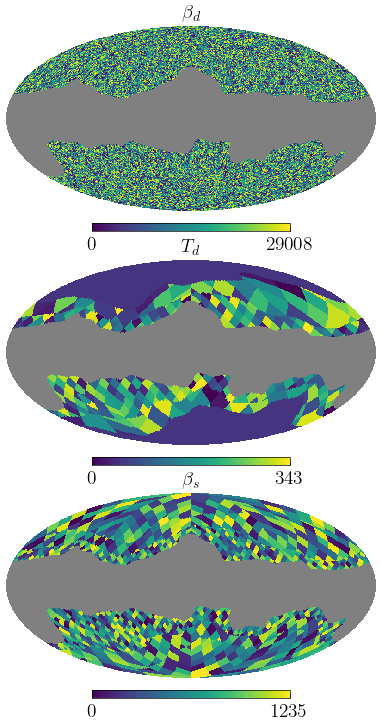

In [10]:
np.random.seed(0)

indices_list = []
maps_list = []
masks = []

nside = 64
npix = nside**2 * 12
ipix = np.arange(npix)

ud_grades = [(64, 0, 8), (64, 4, 8), (64, 8, 16)]

ud_grades = jax.tree.map(lambda x: int(x * nside / 64), ud_grades)
previous_mask_size = {
    "beta_dust_patches": 0,
    "temp_dust_patches": 0,
    "beta_pl_patches": 0,
}
for udgrade, mask_name in zip(ud_grades, ["GAL020", "GAL040", "GAL060"]):
    mask = get_mask(mask_name, nside=nside)
    (indices,) = jnp.where(mask == 1)

    def ud_grade(ipix, nside_in, nside_out):
        if nside_out == 0:
            return np.zeros_like(ipix)
        else:
            lowered = hp.ud_grade(ipix, nside_out=nside_out)
            return hp.ud_grade(lowered, nside_out=nside_in)

    ud_beta_d_map = ud_grade(ipix, nside, udgrade[0])
    ud_temp_d_map = ud_grade(ipix, nside, udgrade[1])
    ud_beta_pl_map = ud_grade(ipix, nside, udgrade[2])

    # These downgraded maps serve as our patch indices.
    patch_indices = {
        "beta_dust_patches": ud_beta_d_map,
        "temp_dust_patches": ud_temp_d_map,
        "beta_pl_patches": ud_beta_pl_map,
    }
    patch_indices = get_cutout_from_mask(patch_indices, indices)

    def normalize_array(arr):
        unique_vals, indices = np.unique(arr, return_inverse=True)
        return indices

    patch_indices = jax.tree.map(normalize_array, patch_indices)
    patch_indices = jax.tree.map(lambda x, p: x + p, patch_indices, previous_mask_size)
    previous_mask_size = jax.tree.map(
        lambda x, p: p + np.unique(x).size, patch_indices, previous_mask_size
    )

    indices_list.append(indices)
    maps_list.append(patch_indices)
    masks.append(mask)


def normalize_array(arr):
    unique_vals, indices = np.unique(arr, return_inverse=True)
    return indices


full_mask = np.logical_or.reduce(masks, axis=0)
(full_indices,) = jnp.where(full_mask == 1)

full_map = combine_masks(maps_list, indices_list, nside)
full_map = get_cutout_from_mask(full_map, full_indices)
full_map = jax.tree.map(normalize_array, full_map)
full_map = get_fullmap_from_cutout(full_map, full_indices, nside)

min_val = 0


def shuffle_labels(arr):
    unique_vals = np.unique(arr[arr != hp.UNSEEN])  # Ignore UNSEEN
    shuffled_vals = np.random.permutation(unique_vals)

    # Create mapping dict
    mapping = dict(zip(unique_vals, shuffled_vals))

    # Vectorized mapping
    shuffled_arr = np.vectorize(lambda x: mapping.get(x, hp.UNSEEN))(arr)
    return shuffled_arr.astype(np.float64)


full_map = jax.tree.map(shuffle_labels, full_map)


figure = plt.figure(figsize=(4, 7))

hp.mollview(
    full_map["beta_dust_patches"],
    title=r"$\beta_d$",
    min=min_val,
    max=np.max(full_map["beta_dust_patches"]),
    cbar=True,
    sub=(3, 1, 1),
    bgcolor=(0, 0, 0, 0),  # Transparent background
)
hp.mollview(
    full_map["temp_dust_patches"],
    title=r"$T_d$",
    min=min_val,
    max=np.max(full_map["temp_dust_patches"]),
    cbar=True,
    sub=(3, 1, 2),
    bgcolor=(0, 0, 0, 0),
)
hp.mollview(
    full_map["beta_pl_patches"],
    title=r"$\beta_s$",
    min=min_val,
    max=np.max(full_map["beta_pl_patches"]),
    cbar=True,
    sub=(3, 1, 3),
    bgcolor=(0, 0, 0, 0),
)
plt.plot()

In [ ]:
nside = 256
npixels = hp.nside2npix(nside)

np.random.seed(0)

GAL020_U = get_mask("GAL020_U")
(indices,) = jnp.where(GAL020_U == 1)

GAL020_U_patch_count = {
    "temp_dust_patches": 5,
    "beta_dust_patches": 2000,
    "beta_pl_patches": 20,
}
GAL020_L_patch_count = {
    "temp_dust_patches": 15,
    "beta_dust_patches": 2000,
    "beta_pl_patches": 25,
}
GAL040_U_patch_count = {
    "temp_dust_patches": 5,
    "beta_dust_patches": 3000,
    "beta_pl_patches": 20,
}
GAL040_L_patch_count = {
    "temp_dust_patches": 10,
    "beta_dust_patches": 3000,
    "beta_pl_patches": 5,
}
GAL060_U_patch_count = {
    "temp_dust_patches": 5,
    "beta_dust_patches": 4000,
    "beta_pl_patches": 5,
}
GAL060_L_patch_count = {
    "temp_dust_patches": 10,
    "beta_dust_patches": 4000,
    "beta_pl_patches": 10,
}

patch_count_list = [
    GAL020_U_patch_count,
    GAL040_U_patch_count,
    GAL060_U_patch_count,
    GAL060_L_patch_count,
    GAL040_L_patch_count,
    GAL020_L_patch_count,
]

indices_list = []
maps_list = []
masks = []

previous_mask_size = {
    "beta_dust_patches": 0,
    "temp_dust_patches": 0,
    "beta_pl_patches": 0,
}

for patch_count, mask_name in zip(
    patch_count_list, ["GAL020_U", "GAL040_U", "GAL060_U", "GAL060_L", "GAL040_L", "GAL020_L"]
):
    mask = get_mask(mask_name, nside)
    (indices,) = jnp.where(mask == 1)

    full_map = jax.tree.map(
        lambda x: find_kmeans_clusters(
            mask, indices, x, jax.random.key(0), max_centroids=4000, initial_sample_size=1
        ),
        patch_count,
    )
    full_map = get_cutout_from_mask(full_map, indices)

    full_map = jax.tree.map(lambda x, p: x + p, full_map, previous_mask_size)
    previous_mask_size = jax.tree.map(
        lambda x, p: p + np.unique(x).size, full_map, previous_mask_size
    )

    maps_list.append(full_map)
    indices_list.append(indices)
    masks.append(mask)

full_full_map = combine_masks(maps_list, indices_list, nside)


def shuffle_labels(arr):
    unique_vals = np.unique(arr[arr != hp.UNSEEN])  # Ignore UNSEEN
    shuffled_vals = np.random.permutation(unique_vals)

    # Create mapping dict
    mapping = dict(zip(unique_vals, shuffled_vals))

    # Vectorized mapping
    shuffled_arr = np.vectorize(lambda x: mapping.get(x, hp.UNSEEN))(arr)
    return shuffled_arr.astype(np.float64)


full_full_map = jax.tree.map(shuffle_labels, full_full_map)

min_val = 0

figure = plt.figure(figsize=(4, 7))

hp.mollview(
    full_full_map["beta_dust_patches"],
    title=r"$\beta_d$",
    min=min_val,
    max=np.max(full_full_map["beta_dust_patches"]),
    cbar=True,
    sub=(3, 1, 1),
    bgcolor=(0, 0, 0, 0),  # Transparent background
)
hp.mollview(
    full_full_map["temp_dust_patches"],
    title=r"$T_d$",
    min=min_val,
    max=np.max(full_full_map["temp_dust_patches"]),
    cbar=True,
    sub=(3, 1, 2),
    bgcolor=(0, 0, 0, 0),
)
hp.mollview(
    full_full_map["beta_pl_patches"],
    title=r"$\beta_s$",
    min=min_val,
    max=np.max(full_full_map["beta_pl_patches"]),
    cbar=True,
    sub=(3, 1, 3),
    bgcolor=(0, 0, 0, 0),
)
plt.plot()